# Proyecto Final Machine Learning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats

sns.set_style("whitegrid")

In [2]:
df = pd.read_csv('AirQualityUCI.csv', sep=';')
df.drop(columns=['Unnamed: 15','Unnamed: 16'], inplace=True)
df.dropna(inplace=True)
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


In [3]:
df.info()
# TODO:
# pasar fecha a tipo fecha
# resto a float (?)
# pasar los -200 a nan
print('Data completa, sin elementos NaN')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   object 
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   object 
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   object 
 13  RH             9357 non-null   object 
 14  AH             9357 non-null   object 
dtypes: float64(8), object(7)
memory usage: 1.1+ MB
Data completa, sin elementos NaN


Tipo de dato de la columna 'RH' es `object`. Esto es dado que los datos en el archivo .csv separan los valores decimales por coma (,) y no por puntos.

In [4]:
cols = [col  for col in df.columns if df[col].dtype == 'O']
for i in cols:
    if i == 'Time':
        df[i] = df[i].str.replace('.',':')
    else:
        df[i] = df[i].str.replace(',','.')

In [5]:
df[df.columns[2:]] = df[df.columns[2:]].astype(float)
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df['Time'] = pd.to_timedelta(df['Time'], errors = 'ignore')
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


In [6]:
print('Perfectooo locoo!!!\n')
df.info()

Perfectooo locoo!!!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   Date           9357 non-null   datetime64[ns] 
 1   Time           9357 non-null   timedelta64[ns]
 2   CO(GT)         9357 non-null   float64        
 3   PT08.S1(CO)    9357 non-null   float64        
 4   NMHC(GT)       9357 non-null   float64        
 5   C6H6(GT)       9357 non-null   float64        
 6   PT08.S2(NMHC)  9357 non-null   float64        
 7   NOx(GT)        9357 non-null   float64        
 8   PT08.S3(NOx)   9357 non-null   float64        
 9   NO2(GT)        9357 non-null   float64        
 10  PT08.S4(NO2)   9357 non-null   float64        
 11  PT08.S5(O3)    9357 non-null   float64        
 12  T              9357 non-null   float64        
 13  RH             9357 non-null   float64        
 14  AH             9357 non-null   floa

# Datos Faltantes
Los datos faltantes del df los reemplazaron con el valor de -200.

In [65]:
df_nan = df.replace(-200,np.nan)
df_nan.index = df_nan['Date'] + df_nan['Time']
df_nan.drop(['Date','Time'],axis=1,inplace=True)
df_nan.drop([x for x in df_nan.columns if 'GT' in x],axis=1,inplace=True)

""" Cuantos nan hay por columna """
df_nan.isna().sum()

PT08.S1(CO)      366
PT08.S2(NMHC)    366
PT08.S3(NOx)     366
PT08.S4(NO2)     366
PT08.S5(O3)      366
T                366
RH               366
AH               366
dtype: int64

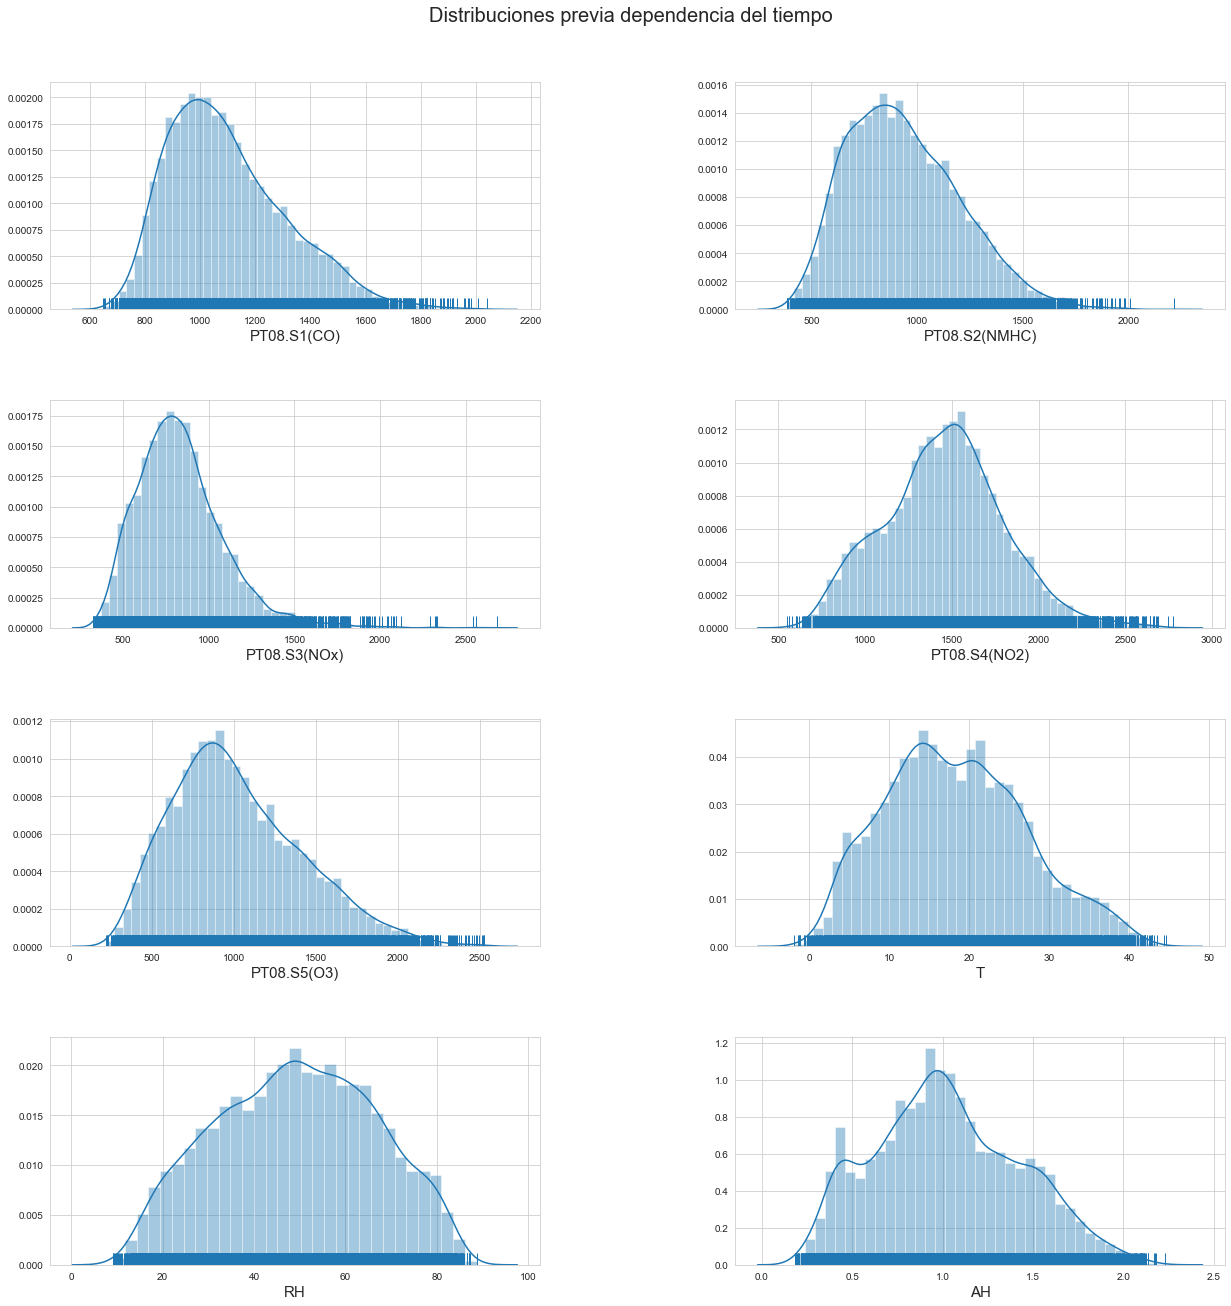

In [66]:
# Vista previa de la distribución de datos sin considerar la dependencia temporal
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=[17, 17])
fig.tight_layout()

# list(map(lambda a : a.remove(), ax[-1,1:]))
fig.suptitle('Distribuciones previa dependencia del tiempo',
             fontsize=20,
             x=0.5,
             y=1.05)

for axis, col in zip(ax.flatten(), df_nan.columns[:]):
    try :
        sns.distplot(df_nan[col], ax=axis, rug=True)
               
    except RuntimeError:
        sns.distplot(df_nan[col], ax=axis, rug=True, kde=False)
    
    axis.set_xlabel(col, fontsize=15)

plt.subplots_adjust(wspace=0.4, hspace=0.4)

In [68]:
antes = pd.concat([df_nan.mean(axis=0).to_frame('mean'),df_nan.var(axis=0).to_frame('var')],axis=1)
antes

,mean,var
PT08.S1(CO),1099.833166,47123.742575
PT08.S2(NMHC),939.153376,71199.011290
PT08.S3(NOx),835.493605,65955.135860
PT08.S4(NO2),1456.264598,119859.143884
PT08.S5(O3),1022.906128,158789.727561
T,18.317829,78.006268
RH,49.234201,299.874765
AH,1.025530,0.163065


In [69]:
import missingno as msno

Text(0.5, 0.98, 'Distribucion de información faltante')

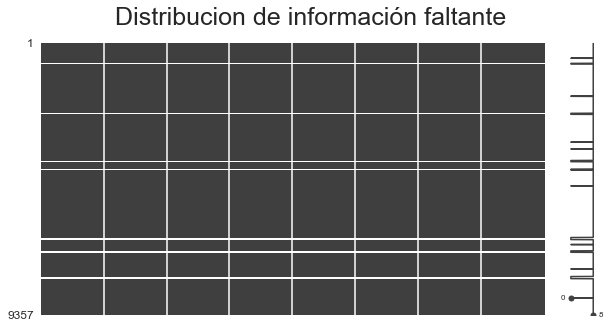

In [70]:
fig =msno.matrix(df_nan[df_nan.isnull().sum().index], 
                 labels=False,
                 sparkline=True, figsize=(10,5), fontsize=10)
fig_copy = fig.get_figure()
fig_copy.suptitle('Distribucion de información faltante', fontsize=25)

In [71]:
for x in df_nan.columns:
    df_nan[x].fillna(method='ffill', inplace=True)

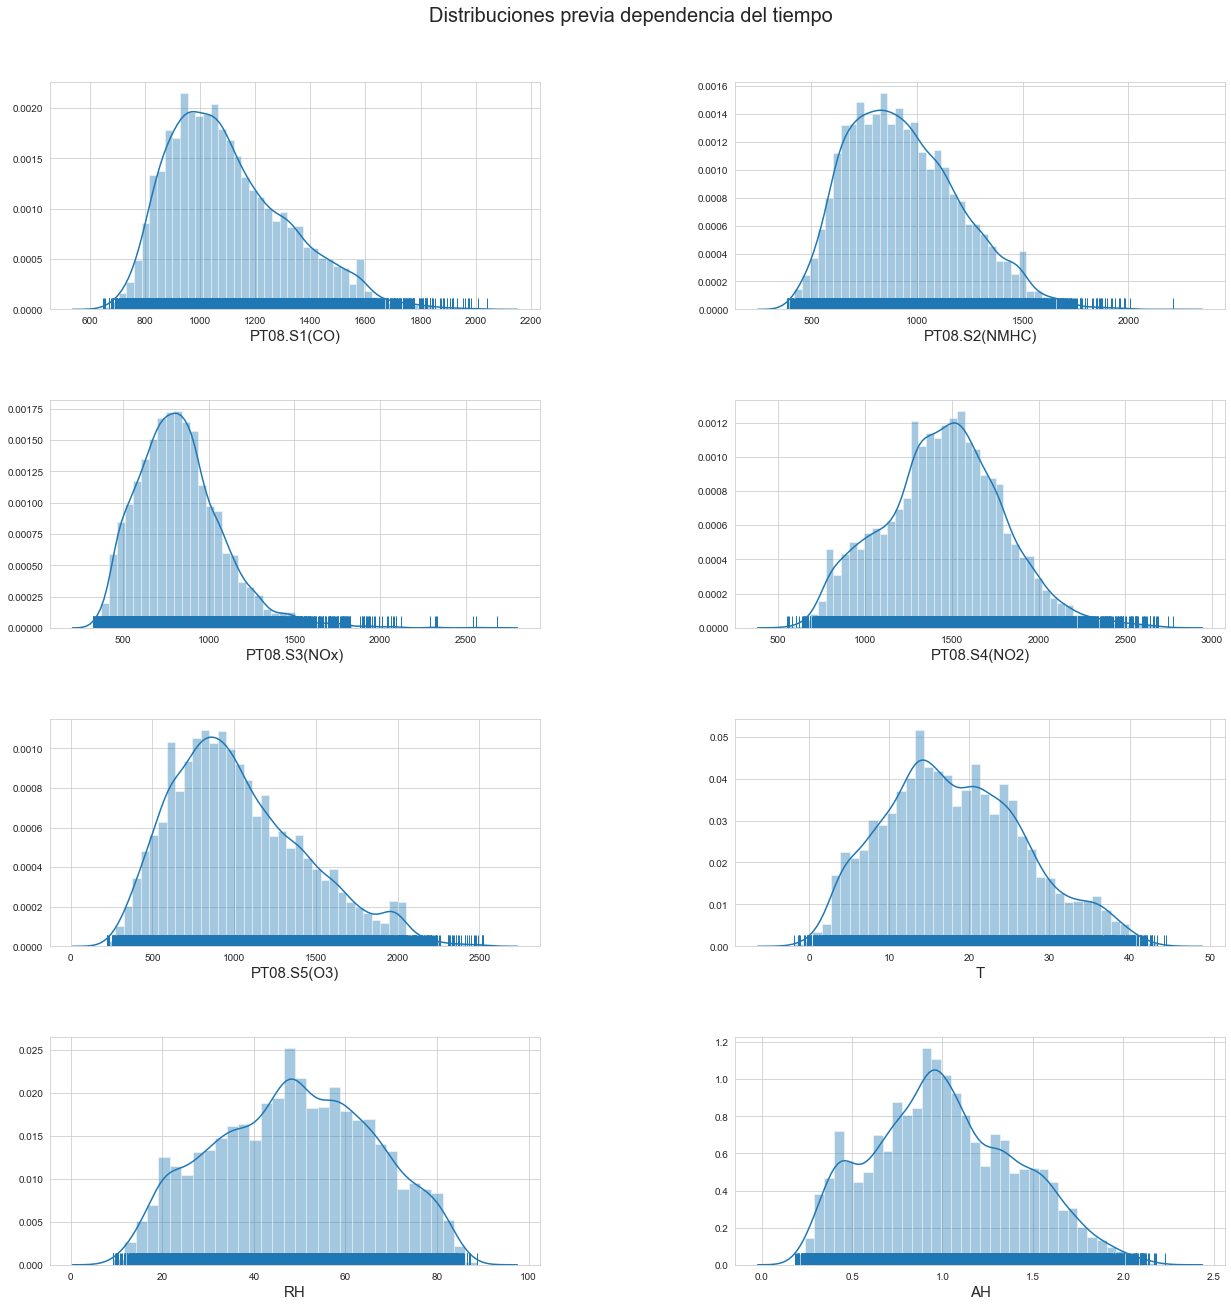

In [72]:
# Vista previa de la distribución de datos sin considerar la dependencia temporal
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=[17, 17])
fig.tight_layout()

fig.suptitle('Distribuciones previa dependencia del tiempo',
             fontsize=20,
             x=0.5,
             y=1.05)

for axis, col in zip(ax.flatten(), df_nan.columns[:]):
    try :
        sns.distplot(df_nan[col], ax=axis, rug=True)
               
    except RuntimeError:
        sns.distplot(df_nan[col], ax=axis, rug=True, kde=False)
    
    axis.set_xlabel(col, fontsize=15)

plt.subplots_adjust(wspace=0.4, hspace=0.4)

In [73]:
despues = pd.concat([df_nan.mean(axis=0).to_frame('mean'),df_nan.var(axis=0).to_frame('var')],axis=1)

In [74]:
antes,despues

(                      mean            var
 PT08.S1(CO)    1099.833166   47123.742575
 PT08.S2(NMHC)   939.153376   71199.011290
 PT08.S3(NOx)    835.493605   65955.135860
 PT08.S4(NO2)   1456.264598  119859.143884
 PT08.S5(O3)    1022.906128  158789.727561
 T                18.317829      78.006268
 RH               49.234201     299.874765
 AH                1.025530       0.163065,
                       mean            var
 PT08.S1(CO)    1102.730362   48218.934021
 PT08.S2(NMHC)   942.548253   72674.114094
 PT08.S3(NOx)    832.742225   65387.308919
 PT08.S4(NO2)   1453.014535  120710.442713
 PT08.S5(O3)    1030.511916  168852.582719
 T                18.317356      77.825620
 RH               48.817431     301.172626
 AH                1.017382       0.163886)

## Matraca prediccion

In [10]:
from pmdarima.arima import auto_arima # hay que instalar esta wea por sia: pip install pmdarima

In [11]:
def train_test_split(df,tamaño = 0.8):
    X_train = df[:int(df.shape[0]*(tamaño))]
    X_test = df[int(df.shape[0]*tamaño):]
    return X_train,X_test

In [12]:
X_train,X_test = train_test_split(df_nan)

In [15]:
def Modelo_auto_arima(df,columna):
    df_col1 = df[[columna]]
    model = auto_arima(df_col1, start_p=1, start_q=1,max_p=7, max_q=7,d=1, max_d=7
                               ,seasonal = True,trace=True,error_action='ignore',suppress_warnings=True, 
                               stepwise=True)
    return model

In [100]:
X_train[['CO(GT)']].isna().sum()

CO(GT)    0
dtype: int64

In [16]:
model = Modelo_auto_arima(X_test,'CO(GT)')

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=4442.875, BIC=4465.012, Time=1.717 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=4559.261, BIC=4570.330, Time=0.372 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=4485.679, BIC=4502.281, Time=0.178 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=4450.741, BIC=4467.344, Time=0.240 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=4557.263, BIC=4562.797, Time=0.061 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=4166.742, BIC=4194.413, Time=2.421 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=4390.110, BIC=4412.247, Time=0.259 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=4164.796, BIC=4198.001, Time=2.175 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=4355.337, BIC=4383.008, Time=0.462 seconds
Fit ARIMA(4,1,1)x(0,0,0,0) [intercept=True]; AIC=4166.754, BIC=4205.494, Time=3.809 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercep

In [19]:
model

ARIMA(maxiter=50, method='lbfgs', order=(3, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [18]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1872
Model:               SARIMAX(3, 1, 1)   Log Likelihood               -2076.398
Date:                Mon, 06 Jul 2020   AIC                           4164.796
Time:                        12:11:02   BIC                           4198.001
Sample:                             0   HQIC                          4177.029
                               - 1872                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -7.269e-05      0.001     -0.098      0.922      -0.002       0.001
ar.L1          1.0641      0.022     49.060      0.000       1.022       1.107
ar.L2         -0.3982      0.029    -13.631      0.000      -0.455      -0.341
ar.L3          0.0488      0.023      2.081      0.037       0.003       0.095
ma.L1         -0.9647      0.008   -115.133      0.000      -0.981      -0.948
sigma2         0.5384      0.012     46.412      0.000       0.516       0.561
===================================================================================
Ljung-Box (Q):                      372.94   Jarque-Bera (JB):              1067.49
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.94   Skew:                             0.63
Prob(H) (two-sided):                  0.45   Kurtosis:                         6.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""